In [24]:
from astropy.stats import biweight_midvariance, biweight_location

In [25]:
from astropy.io import fits
from matplotlib import pyplot as plt
% matplotlib inline

In [26]:
import numpy as np

In [27]:
c = fits.getdata("data/outcube_median_022.fits.gz")

In [28]:
xc,yc = 48.,65.
r = 10.

xx = np.arange(c.shape[2]) - xc
yy = np.arange(c.shape[1]) - yc
XX,YY = np.meshgrid(xx,yy)
dd = np.sqrt(XX**2. + YY**2.)

ii = dd < r

mm = np.zeros(c.shape[0])
ll = np.zeros(c.shape[0])
ss = np.zeros(c.shape[0])
vv = np.zeros(c.shape[0])
for i in range(c.shape[0]):
    vv[i] = np.sqrt( biweight_midvariance( c[i][ii] ) )
    ss[i] = np.std( c[i][ii] )
    mm[i] = np.mean(c[i][ii] )   
    ll[i] = biweight_location(c[i][ii] )   

In [29]:
zz = np.arange(c.shape[0])
p = np.polyfit(zz, vv, deg = 100)

/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/numpy/lib/polynomial.py:578: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/ipykernel_launcher.py:2: RankWarning: Polyfit may be poorly conditioned
  


In [30]:
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(zz, vv, k=5, s=2.)

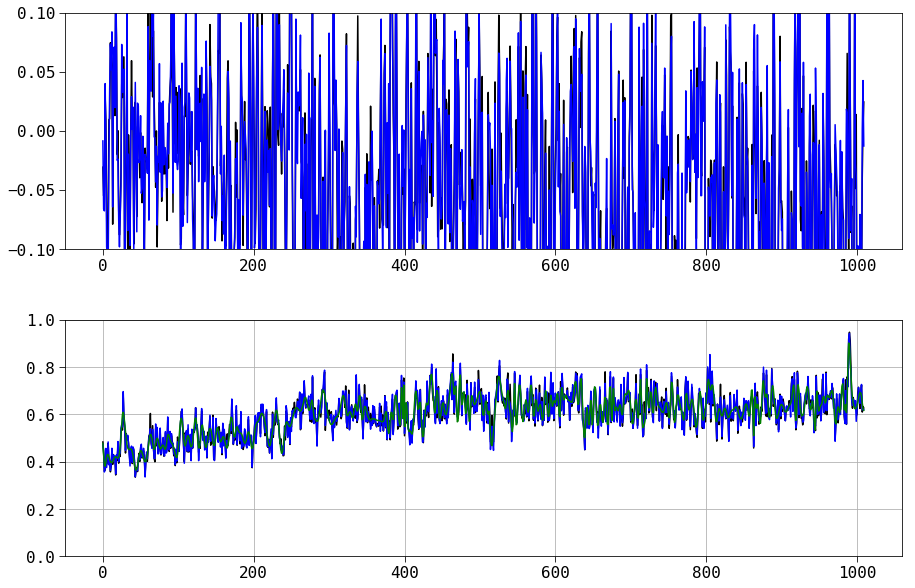

In [32]:
f = plt.figure(figsize=[15,10])
plt.subplot(2,1,1)
plt.plot(mm)
plt.plot(ll)
plt.ylim([-.1,.1])
plt.subplot(2,1,2)
plt.plot(ss)
plt.plot(vv)
plt.plot(spl(zz))
plt.ylim([0.,1.])
plt.grid()



In [33]:
from numpy import random
random.seed(42)
nc = np.zeros_like(c)
N = nc.shape[1] * nc.shape[2]
for i,z in enumerate(zz):
    ns = random.normal(scale = spl(zz[i]), size = N)
    nc[i] = ns.reshape(nc[0].shape)

In [11]:
h = fits.PrimaryHDU(nc)
nc[c == 0.] = 0.

h.writeto("nc.fits.gz", overwrite=True)

!ds9 outcube_median_022.fits.gz nc.fits

In [12]:
import numpy as np
    

In [13]:
w = 31
m = 9

ss = []
for i in range(c.shape[0]):

    subim =  c[i,int(yc-w/2):int(yc+w/2),int(xc-w/2):int(xc+w/2)]
    M = []
    for j in range(0,w-m):
        for k in range(0,w-m):
            M.append(subim[j:j+m,k:k+m].flatten() )
    M = np.array(M)

    cov = np.cov(M.T)
    
    ss.append( cov[m**2//2].reshape([m,m]) )
    
ss=np.array(ss)



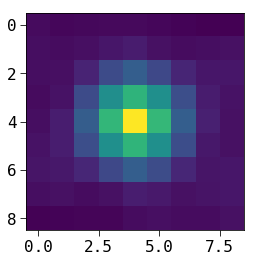

In [14]:
w = 20
i = 45
plt.imshow(  np.mean(ss[i*w:i*w+w], axis=0) )

In [15]:
kernel = np.mean(ss, axis=0)
kernel = kernel/np.sum(kernel)

In [16]:
from scipy.signal import fftconvolve

In [17]:
cnc = fftconvolve(kernel,nc[0])

/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


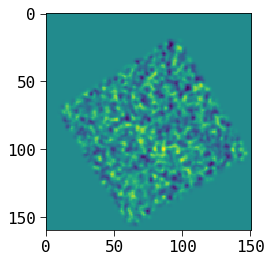

In [18]:
plt.imshow(cnc)

In [19]:
maxiter = 15
f = 0.5
DEBUG = True

from numpy import random
random.seed(42)
nc = np.zeros_like(c)
N = nc.shape[1] * nc.shape[2]
for i,z in enumerate(zz):
    i = 100
    print(i)
    #i = 500
    # this is the target sigma we need to reach 
    # after taking the covariance into account
    target_sigma = spl(zz[i]) 
    scale = target_sigma * 3.53
    
    iter = 0
    while True:
        if DEBUG:
            print("Iteration {}".format(iter))
            print("target_sigma {}".format(target_sigma))
        if iter > maxiter:
            break
        # generate random noise image (w/o) covaraince
        ns = random.normal(scale = scale, size = N)
        ns = ns.reshape(nc[0].shape)
        # convolve with interpical covariance kernel
        cns = fftconvolve(ns, kernel, mode='same')
        # compute resulting standard deviation
        s = np.std(cns)
        if DEBUG:
            print("Scale {}".format(scale))
            print("sigma {}".format(s))
            print("scale/target_sigma = {}".format(scale/target_sigma))
            print("sigma/target_sigma = {}".format(s/target_sigma))
        if 0.99 < s/target_sigma < 1.01:
            break
        # adjust noise scale by relative difference
        dscale =  scale / (s/target_sigma) - scale
        if DEBUG:
            print("dscale {}".format(dscale))
        scale = scale + f * dscale
        if DEBUG:
            print("New scale {}".format(scale))
            print("")

        iter += 1
    nc[i] = cns
    break

100
Iteration 0
target_sigma 0.4584829700193823
Scale 1.6184448841684196
sigma 0.4009259689891847
scale/target_sigma = 3.53
sigma/target_sigma = 0.8744620742886821
dscale 0.2323442257937467
New scale 1.734616997065293

Iteration 1
target_sigma 0.4584829700193823
Scale 1.734616997065293
sigma 0.44098622068260424
scale/target_sigma = 3.783383703416426
sigma/target_sigma = 0.9618377333927182
dscale 0.06882337218153212
New scale 1.7690286831560589

Iteration 2
target_sigma 0.4584829700193823
Scale 1.7690286831560589
sigma 0.4576011194232594
scale/target_sigma = 3.858439241660979
sigma/target_sigma = 0.998076590290615


/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


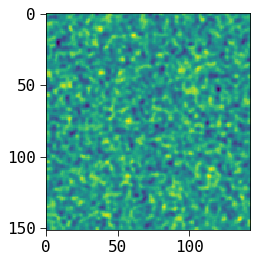

In [20]:
plt.imshow(cns)

In [22]:
h = fits.PrimaryHDU(nc)
nc[c == 0.] = 0.

h.writeto("data/nc.fits.gz", overwrite=True)

!ds9 outcube_median_022.fits.gz nc.fits.gz

In [176]:
scale

array(0.4771508253946777)

In [193]:
1.5973915662471425/0.4771508253946777

3.34777072831395

In [221]:
!ds9 outcube_median_022.fits.gz nc.fits.gz

In [ ]:
!python  filter_cube.py nc.fits.gz 2. s2nc.fits.gz

In [222]:
!ds9 s2outcube_median_022.fits.gz s2nc.fits.gz